In [1]:
#from sources.vgg16 import VGG16
from sources.InceptionV3 import InceptionV3
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from wandb.keras import WandbMetricsLogger

In [2]:
import wandb
wandb.init(
    project="brain-tumor-classification",
    name="InceptionV3",	
    config={
        "learning_rate": 0.0001,
        "epochs": 10,
        "batch_size": 10,
        "loss_function": "categorical_crossentropy",
        "architecture": "InceptionV3_GP",
    }
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rijalsankalp (sankalpa). Use `wandb login --relogin` to force relogin


In [3]:
train_dir = "input/Training"
test_dir = "input/Testing"
target_size = (128, 128)
batch_size = 10

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.15)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', validation_split = 0.15)

In [5]:
og_train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training',
    shuffle=True
)

og_validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=1,
    class_mode='categorical',
    subset = 'validation',
    shuffle=True
)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


In [6]:
aug_train_data = datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training',
    shuffle=True
)

aug_validation_data = datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=1,
    class_mode='categorical',
    subset = 'validation',
    shuffle=True
)


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


In [7]:
class_indices = og_train_data.class_indices
class_indices = {v:k for k, v in class_indices.items()}
print(class_indices)

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


In [8]:
#two generators should be combined aferall
def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

In [9]:
train_steps = (len(og_train_data)+len(aug_train_data)) // batch_size
validation_steps = (len(og_validation_data)+len(aug_validation_data)) // batch_size

In [10]:
model = InceptionV3(input_shape=(128,128,3), num_classes=4).build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [11]:
num_epochs = 26
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])	

In [12]:
# Train the model on GPU
history = model.fit(combine_gen(og_train_data, aug_train_data),
                              steps_per_epoch=train_steps,
                              epochs=10,
                              validation_data= combine_gen(og_validation_data, aug_validation_data),
                              validation_steps = validation_steps,
                              callbacks=[WandbMetricsLogger(log_freq = "batch")]
                   )

filename = "savedmodels/brain_tumor_InceptionV3.h5"
# Save the trained model to disk
model.save(filename)

Epoch 1/10
97/97 [==============================] - 96s 800ms/step - loss: 0.7010 - accuracy: 0.7423 - precision: 0.8666 - recall: 0.5959 - val_loss: 1.5332 - val_accuracy: 0.4035 - val_precision: 0.4049 - val_recall: 0.3860
Epoch 2/10
97/97 [==============================] - 71s 735ms/step - loss: 0.3628 - accuracy: 0.8660 - precision: 0.8874 - recall: 0.8454 - val_loss: 0.5835 - val_accuracy: 0.7836 - val_precision: 0.7976 - val_recall: 0.7836
Epoch 3/10
97/97 [==============================] - 61s 626ms/step - loss: 0.3059 - accuracy: 0.8887 - precision: 0.8992 - recall: 0.8649 - val_loss: 0.7097 - val_accuracy: 0.7076 - val_precision: 0.7202 - val_recall: 0.7076
Epoch 4/10
97/97 [==============================] - 61s 625ms/step - loss: 0.2539 - accuracy: 0.9010 - precision: 0.9143 - recall: 0.8907 - val_loss: 0.8566 - val_accuracy: 0.6901 - val_precision: 0.6951 - val_recall: 0.6667
Epoch 5/10
97/97 [==============================] - 67s 693ms/step - loss: 0.2551 - accuracy: 0.9052

In [14]:
#collecting the test datset
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

#y_pred = model.predict(test_data, callbacks=[WandbCallback(), tensorboard_callback])
y_pred = model.predict(test_data, callbacks=[WandbMetricsLogger(log_freq = "batch")])
# Convert the predicted probabilities to labels
y_pred_labels = tf.argmax(y_pred, axis=1)
y_true_labels = tf.constant(test_data.labels, dtype=tf.int64, shape=[1311,])
y_pred_labels = y_pred_labels.numpy().tolist()
y_true_labels = y_true_labels.numpy().tolist()

Found 1311 images belonging to 4 classes.
132/132 [==============================] - 34s 249ms/step


In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score,log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay


precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average='weighted')


cm = confusion_matrix(y_true_labels, y_pred_labels)
test_accuracy = accuracy_score(y_true_labels, y_pred_labels)
test_loss = log_loss(y_true_labels, y_pred)

In [20]:
wandb.log({
    "test_loss": test_loss,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1_score": f1_score,
    "test_accuracy": test_accuracy,
    "roc" : wandb.plot.roc_curve( y_true=y_true_labels, y_probas=y_pred,
                        labels=['glioma', 'meningioma', 'no_tumor', 'pituitary'],
                        title="ROC"),
    "test_confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                            y_true=y_true_labels,
                                                            preds=y_pred_labels,
                                                            class_names=['glioma', 'meningioma', 'no_tumor', 'pituitary'],
                                                            title="Test Confusion Matrix")
})

In [ ]:
wandb.finish()

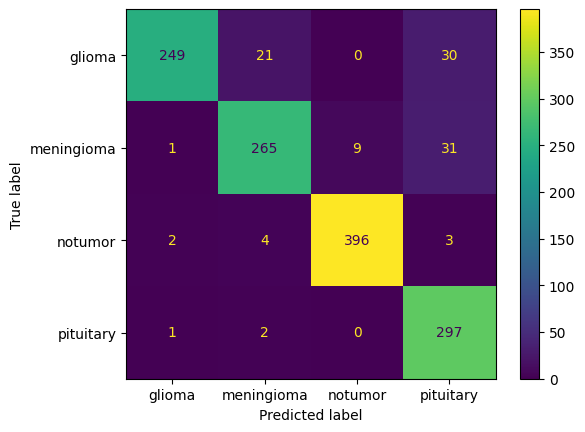

In [21]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['glioma','meningioma','notumor', 'pituitary'])
display.plot()